Нашей целью будет предсказать индивидуальные медицинские расходы граждан США, оплачиваемые медицинской страховкой.

In [56]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt#для визуализации
import seaborn as sns #для визуализации
from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #разделение выборки
import plotly.express as px
%matplotlib inline
plt.style.use('seaborn')

C:\Users\lepni\AppData\Local\Temp\ipykernel_512\2037280818.py:11: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



In [57]:
df = pd.read_csv('insurance.csv', sep=',')
print(df.shape, '\n')
print(df.isnull().sum(), '\n')
print(df.dtypes, '\n')

(1338, 7) 

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64 

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object 



Итак, набор данных содержит следующие столбцы:

age — возраст страхователя;
sex — пол;
bmi — индекс массы тела (\(кг/м^{2}\)), в идеале — от 18.5 до 24.9;
children — количество детей, охваченных медицинской страховкой;
smoker — является ли человек курящим;
region — район проживания в США (северо-восток, юго-восток, северо-запад, юго-запад);
charges (целевой признак) — индивидуальные медицинские расходы, оплачиваемые медицинской страховкой.

In [58]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [59]:
df.describe(include='object')

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


In [60]:
#Создаем копию данных для облегчения работы с изменениями в таблице
df_for_work = df.copy()

In [61]:
types = df_for_work.dtypes
num_features = list(types[(types!='object')].index)
nn_features = list(types[(types =='object')].index)
num_features

['age', 'bmi', 'children', 'charges']

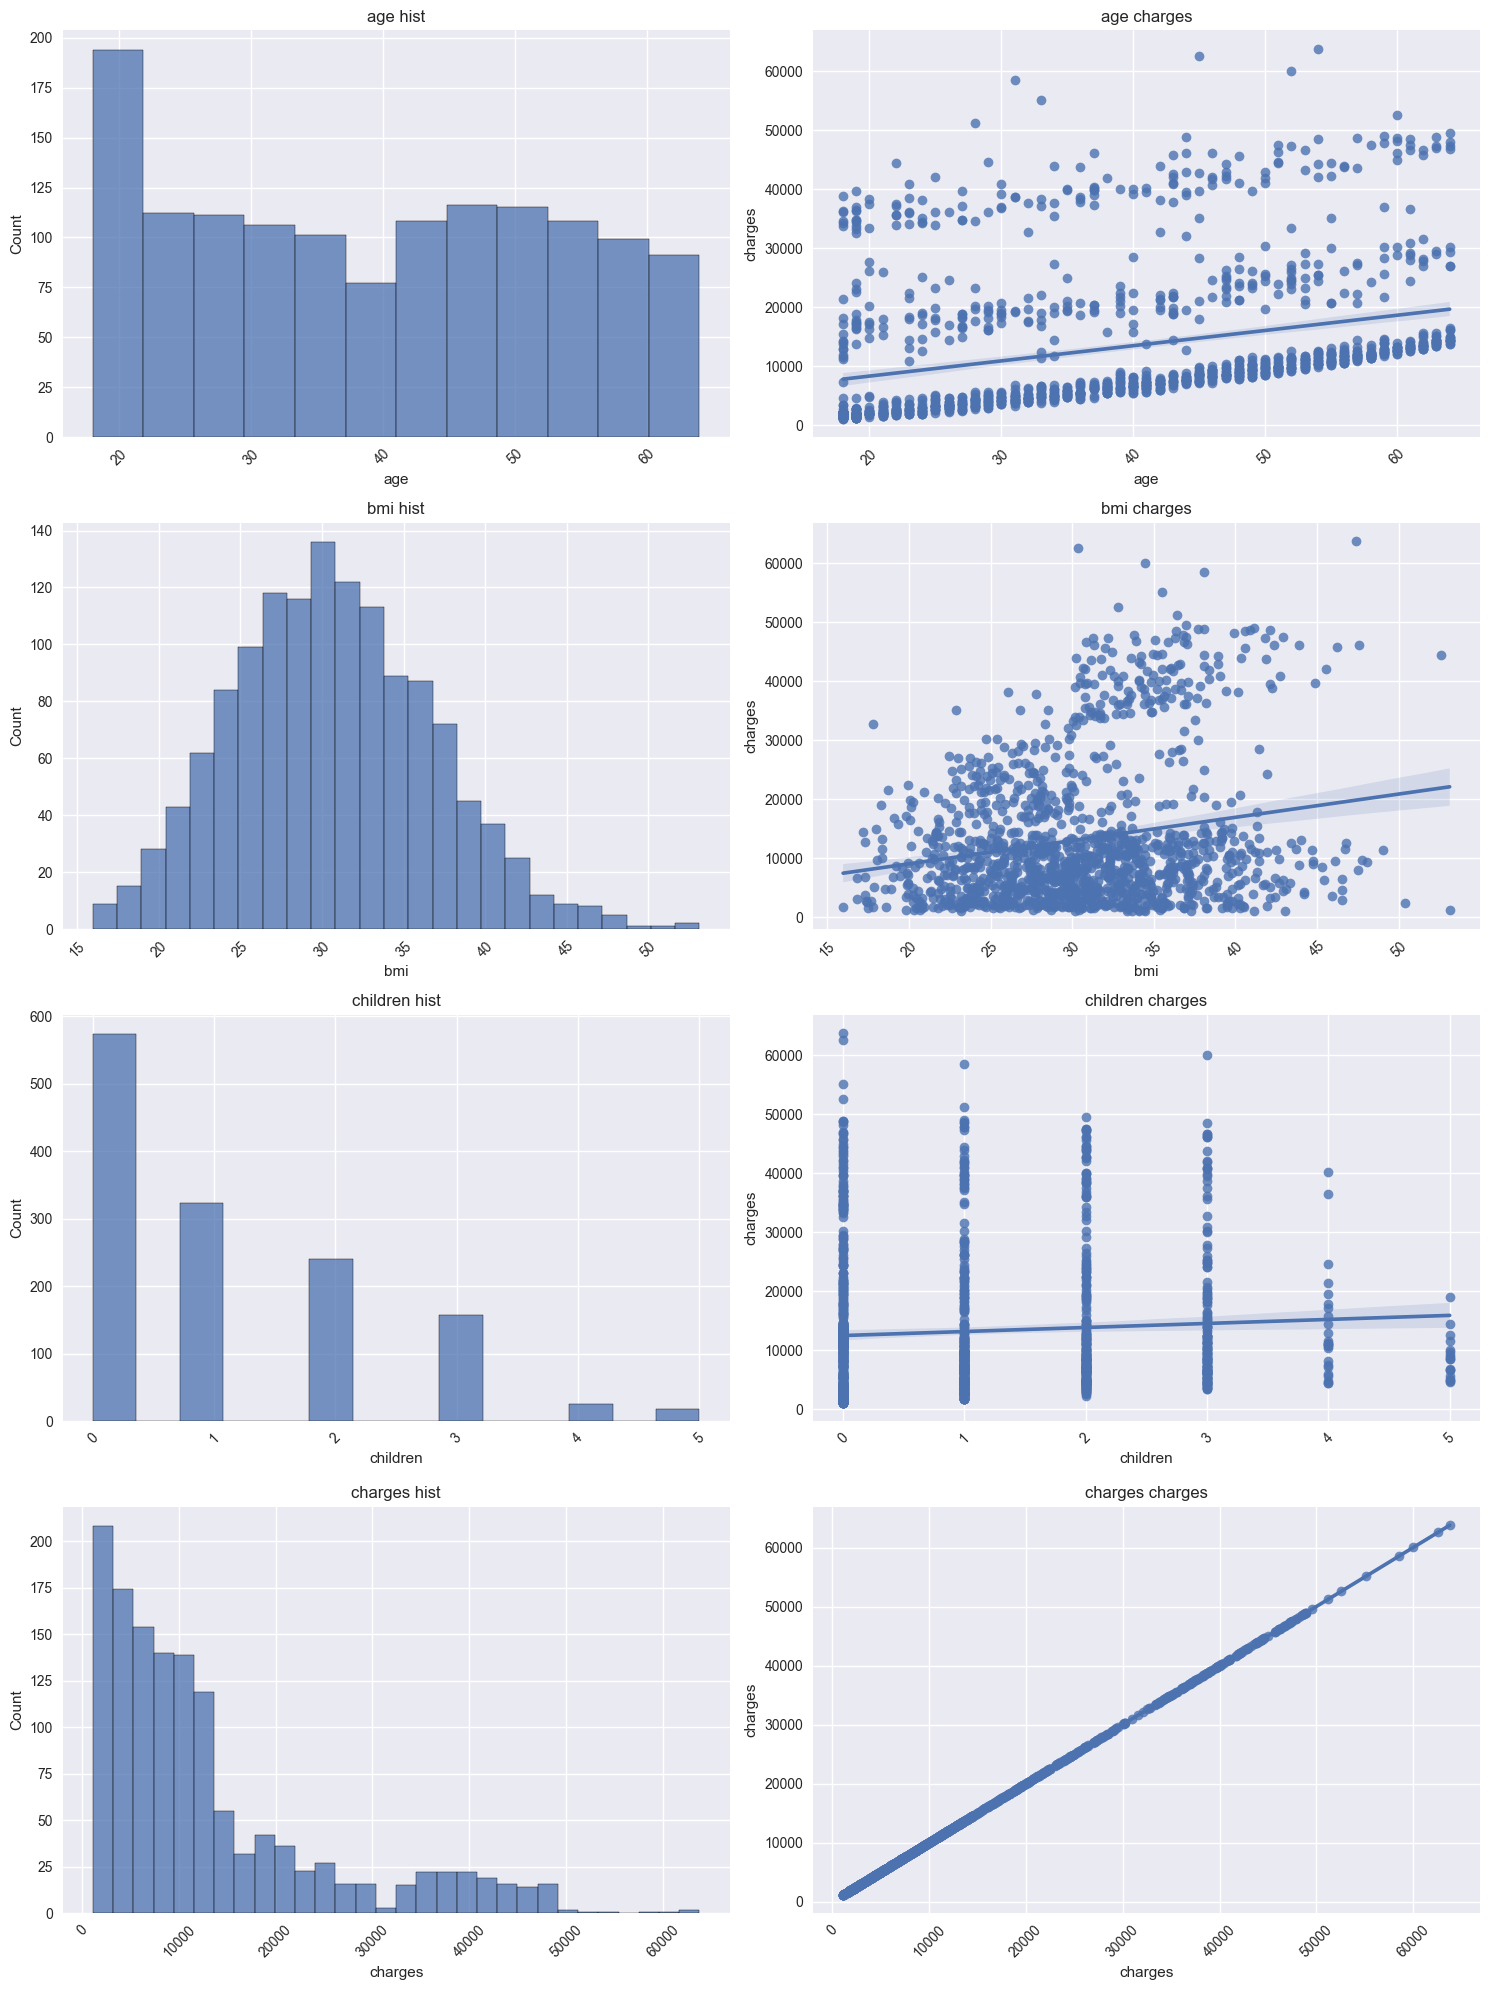

In [62]:
n = len(num_features) #количество числовых признаков
fig, axis = plt.subplots(n, 2, figsize = (15, 20)) # фигура + n х 2 координатных плоскостей
for i, feature in enumerate(num_features): #i- индекс, feature - название признака в таблице
    #Строим гистограмму распределения признака 
    histplot = sns.histplot(data=df_for_work, x=feature, ax=axis[i][0])
    #Добавляем подпись графику
    histplot.set_title('{} hist'.format(feature))
    #Добавляем поворот отметок на оси абсцисс
    histplot.xaxis.set_tick_params(rotation=45)
    #Строим диаграмму рассеяния + линейную регрессию
    regplot = sns.regplot(data=df_for_work, x=feature, y='charges', ax=axis[i][1])
    #Добавляем подпись графику
    regplot.set_title('{} charges'.format(feature))
    #Добавляем поворот отметок на оси абсцисс
    regplot.xaxis.set_tick_params(rotation=45)
plt.tight_layout()

C:\Users\lepni\AppData\Local\Temp\ipykernel_512\503235139.py:3: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<AxesSubplot: >

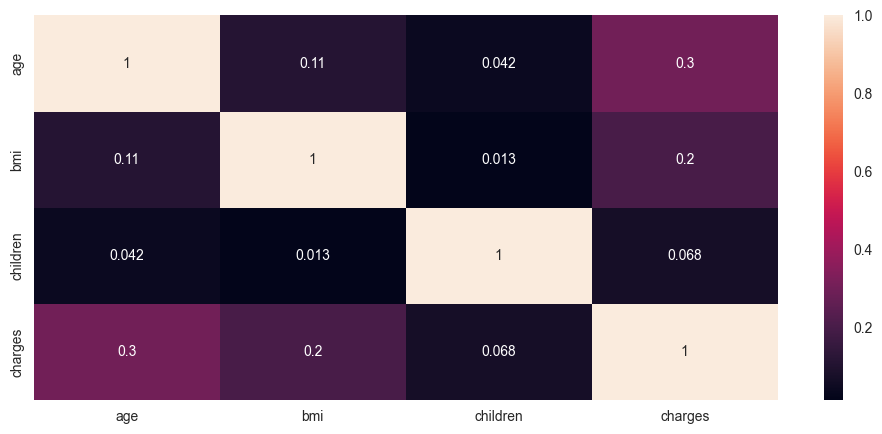

In [63]:
#строим тепловую карту корреляций
fig = plt.figure(figsize=(12,5))
sns.heatmap(df_for_work.corr(), annot=True)

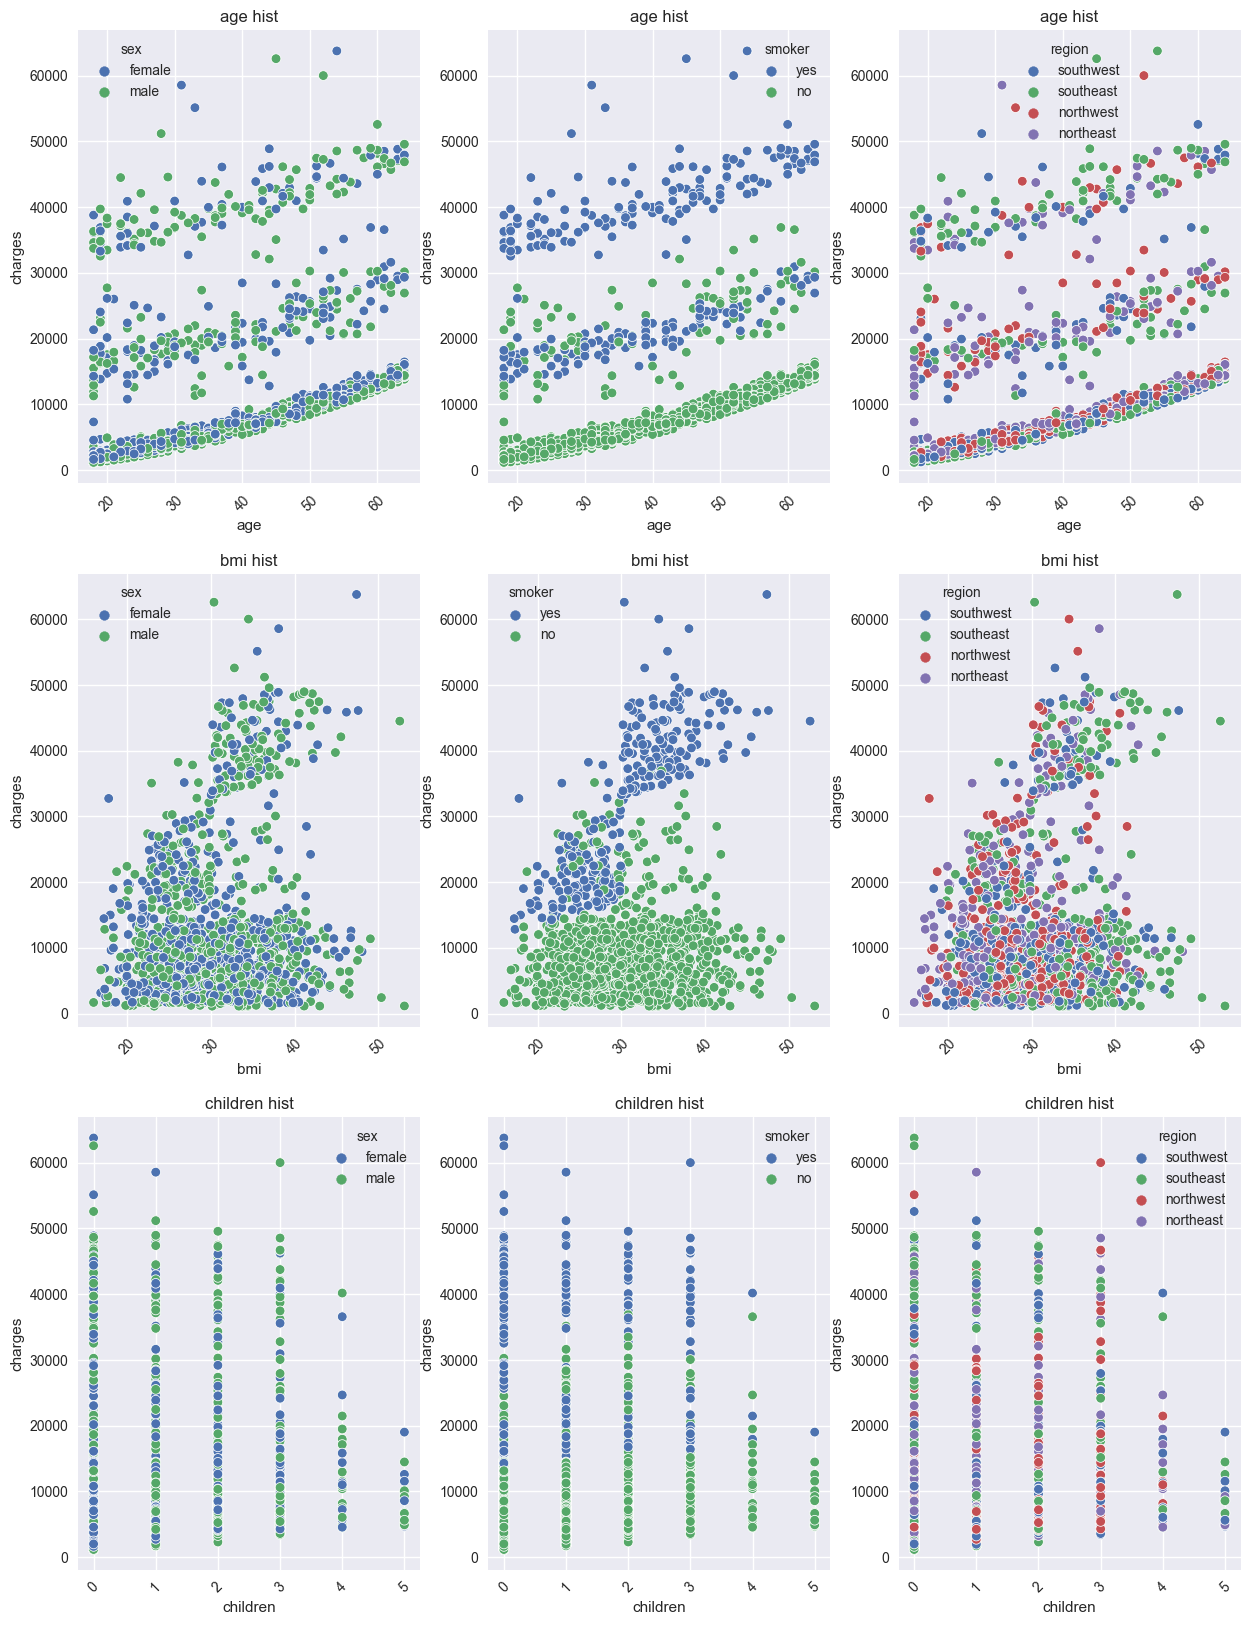

In [64]:
num_features.remove('charges')
fig, axis = plt.subplots(len(num_features), len(nn_features),figsize = (15, 20)) # фигура + n х 2 координатных плоскостей
for i, feature in enumerate(num_features): #i- индекс, feature - название признака в таблице
    for j in range(len(nn_features)):
        #Строим гистограмму распределения признака 
        histplot = sns.scatterplot(data=df_for_work, x=feature, y='charges', hue=nn_features[j], ax=axis[i][j])
        #Добавляем подпись графику
        histplot.set_title('{} hist'.format(feature))
        #Добавляем поворот отметок на оси абсцисс
        histplot.xaxis.set_tick_params(rotation=45)

In [65]:
#кодируем бинарные категориальные признак
df_for_work['smoker'] = df_for_work['smoker'].apply(lambda x: 0 if x =='no' else 1)
df_for_work['sex'] = df_for_work['smoker'].apply(lambda x: 0 if x =='female' else 1)
df_for_work = pd.get_dummies(df_for_work)
"""coder = ce.OneHotEncoder(cols=['region'], use_cat_names=True) # указываем столбец для кодирования
type_bin = coder.fit_transform(df_for_work['region'])
df_for_work = pd.concat([df_for_work, type_bin], axis=1)"""
df_for_work.head(3)

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,1,27.90,0,1,16884.9240,0,0,0,1
1,18,1,33.77,1,0,1725.5523,0,0,1,0
2,28,1,33.00,3,0,4449.4620,0,0,1,0


In [66]:
#X - матрица наблюдений, y - столбец правильных ответов
features = df_for_work.drop('charges', axis=1).columns
X, y = df_for_work[features], df_for_work['charges'] 

In [67]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Выводим размеры полученных выборок
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1070, 9)
Test shape: (268, 9)


In [68]:
def print_metrics(y_train, y_train_predict, y_test, y_test_predict):
    print('Train R^2: {:.3f}'.format(metrics.r2_score(y_train, y_train_predict)))
    print('Train MAE: {:.3f}'.format(metrics.mean_absolute_error(y_train, y_train_predict)))
    print('Train MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_train, y_train_predict)*100))
    print('\n')
    print('Test R^2: {:.3f}'.format(metrics.r2_score(y_test, y_test_predict)))
    print('Test MAE: {:.3f}'.format(metrics.mean_absolute_error(y_test, y_test_predict)))
    print('Train MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_test, y_test_predict)*100))

In [69]:
#Инициализируем объект класса линейная регрессия
lr = linear_model.LinearRegression()
#Обучаем модель - ищем параметры
lr.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.742
Train MAE: 4208.219
Train MAPE: 42.204


Test R^2: 0.784
Test MAE: 4182.012
Train MAPE: 46.928


In [70]:
#Составляем таблицу из признаков и их коэффициентов
w_df = pd.DataFrame({'Features': features, 'Coefficients': lr.coef_})
#Составляем строку таблицы со свободным членом
intercept_df =pd.DataFrame({'Features': ['INTERCEPT'], 'Coefficients': lr.intercept_})
coef_df = pd.concat([w_df, intercept_df], ignore_index=True)
display(lr.intercept_)

-12399.022163836898

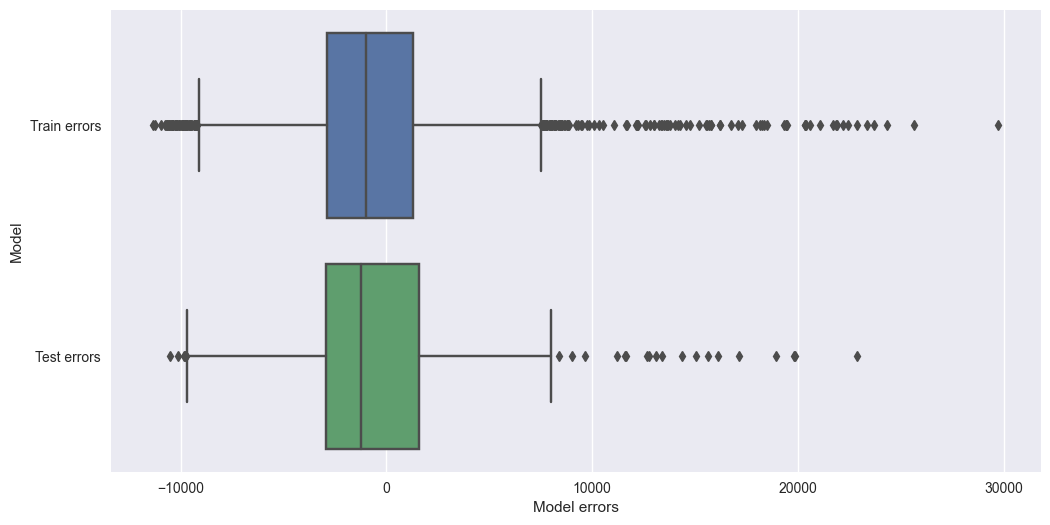

In [72]:
#Визуализируем ошибки
fig, ax = plt.subplots(figsize=(12, 6)) #фигура + координатная плоскость
#Ошибки модели на тренировочной выборке 
y_train_errors = y_train - lr.predict(X_train)
#Ошибки модели на тестовой выборке
y_test_errors = y_test - lr.predict(X_test)
#Для удобства визуализации составим DataFrame из ошибок
predict_df = pd.DataFrame(
    {'Train errors': y_train_errors, 
     'Test errors': y_test_errors
    }
)
#Строим boxplot для ошибок
sns.boxplot(data=predict_df, orient='h', ax=ax)
ax.set_xlabel('Model errors') #название оси абсцисс
ax.set_ylabel('Model'); #название оси ординат

In [ ]:
fig1 = px.box(y_train-y_train_pred)
fig1.show()
fig2 = px.box(y_test-y_test_pred)
fig2.show()


In [ ]:
#Создаем объект для min-max нормализации
scaler = preprocessing.MinMaxScaler()
#scaler_test =preprocessing.MinMaxScaler()
#Вычисляем параметры для нормализации - min и max для каждого столбца
scaler.fit(X_train)

#Производим преобразование для каждой из выборок
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Создаем объект для генерации полиномиальных признаков степени 2
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
#Вычисляем параметры генерации - результирующее количество признак
poly.fit(X_train_scaled)
#Производим преобразование для каждой из выборок
X_train_scaled_poly = poly.transform(X_train_scaled)
X_test_scaled_poly = poly.transform(X_test_scaled)

print('Train shape: {}'.format(X_train_scaled_poly.shape))
print('Test shape: {}'.format(X_test_scaled_poly.shape))

Train shape: (1070, 54)
Test shape: (268, 54)


In [ ]:
#Инициализируем объект класса линейная регрессия
lr_pol = linear_model.LinearRegression()
#Обучаем модель - ищем параметры
lr_pol.fit(X_train_scaled_poly, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = lr_pol.predict(X_train_scaled_poly)
y_test_pred = lr_pol.predict(X_test_scaled_poly)
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.840
Train MAE: 2917.585
Train MAPE: 30.009


Test R^2: 0.869
Test MAE: 2698.916
Train MAPE: 29.753


In [ ]:
lr_pol .coef_

array([-4.37690604e+16,  3.55877495e+15,  4.21528596e+15, -8.42773788e+15,
       -9.98020454e+14, -8.71516546e+15,  5.24432512e+15,  1.14931855e+16,
       -7.64650307e+15,  8.44000000e+03, -3.88084151e+14,  6.84000000e+02,
       -1.10000000e+03,  2.30000000e+02,  4.37690604e+16,  4.37690604e+16,
        4.37690604e+16,  4.37690604e+16, -1.45515886e+14, -2.14513982e+14,
        6.20694401e+13, -1.81087877e+14,  1.51045583e+14,  5.58486526e+13,
        4.83905365e+13,  3.78587689e+13, -8.84070312e+03,  1.55672266e+03,
        5.42805330e+04, -4.21528596e+15, -4.21528596e+15, -4.21528596e+15,
       -4.21528596e+15, -2.49300000e+03, -2.18075000e+03,  8.42773788e+15,
        8.42773788e+15,  8.42773788e+15,  8.42773788e+15,  1.82648168e+15,
       -8.28461228e+14, -8.28461228e+14, -8.28461228e+14, -8.28461228e+14,
       -2.14766028e+15,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -1.61071509e+16,  0.00000000e+00,  0.00000000e+00, -2.23560112e+16,
        0.00000000e+00, -

In [ ]:
#Создаём объект класса линейной регрессии с L1-регуляризацией
lasso_lr_poly = linear_model.Lasso(max_iter =2000)
#Обучаем модель
lasso_lr_poly.fit(X_train_scaled_poly, y_train)
#Делаем предсказание для тренировочной выборки
y_train_predict_poly = lasso_lr_poly.predict(X_train_scaled_poly)
#Делаем предсказание для тестовой выборки
y_test_predict_poly = lasso_lr_poly.predict(X_test_scaled_poly)

Train R^2: 0.840
Test R^2: 0.869


In [ ]:
#Выводим результирующие метрики
print_metrics(y_train, y_train_predict_poly, y_test, y_test_predict_poly)

Train R^2: 0.840
Train MAE: 2900.605
Train MAPE: 29.857


Test R^2: 0.869
Test MAE: 2681.836
Train MAPE: 29.728


In [ ]:
#создаем логарифмированный целевой признак цены
y_train_log = np.log(y_train)


In [ ]:
#Инициализируем объект класса линейная регрессия с L2-регуляризацией 
ridge_lr_poly = linear_model.Ridge()
#Обучаем модель предсказывать логарифм целевого признака
ridge_lr_poly.fit(X_train_scaled_poly, y_train_log)
#Делаем предсказание для каждой из выборок
#Если обучили на логарифме, то от результата необходимо взять обратную функцию - экспоненту
y_train_pred = np.exp(ridge_lr_poly.predict(X_train_scaled_poly))
y_test_pred = np.exp(ridge_lr_poly.predict(X_test_scaled_poly))
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.819
Train MAE: 2654.294
Train MAPE: 18.561


Test R^2: 0.862
Test MAE: 2380.025
Train MAPE: 18.045
